# DAY 5: Classification - decision trees, random forests and k-NN classifiers

### Machine Learning and Computational Statistics (DSC6232)

#### Instructors: Weiwei Pan, Melanie Fernandez, Pavlos Protopapas

#### Due: July 29th, 2:00 pm Kigali Time

**First name**: _________________________________________________________


**Last name**: _____________

## Learning Goals:

1. compare different classification approaches (logistic regression, polynomial logistic regression, decision trees, and random forest): what are their pros and cons?
2. review concepts of high-variance and overfitting for classification
3. explore variance reduction

### Import important libraries

In [10]:
import io
# from google.colab import files

import numpy as np
import pandas as pd
import scipy as sp
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#### Auxiliary functions to generate and visualize data. 
**No need to read through!**

In [11]:
def scatter_plot_data(x, y, ax):
    '''
    scatter_plot_data scatter plots the satellite data. A point in the plot is colored 'green' if 
    vegetation is present and 'gray' otherwise.
    
    input:
       x - a numpy array of size N x 2, each row is a location, each column is a coordinate
       y - a numpy array of length N, each entry is either 0 (no vegetation) or 1 (vegetation)
       ax - axis to plot on
    returns: 
       ax - the axis with the scatter plot
    '''
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='green', label='vegetation')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='gray', label='nonvegetation')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.legend(loc='best')
    return ax

def plot_decision_boundary(x, y, model, ax, plot_boundary_only=False, poly_degree=1):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a location, each column is a coordinate
       y - a numpy array of length N, each entry is either 0 (non-vegetation) or 1 (vegetation)
       model - the 'sklearn' classification model
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    if not plot_boundary_only:
        ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='green', label='vegetation')
        ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='gray', label='non-vegetation')
    
    # Create mesh
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree)
        xx = polynomial_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    if not plot_boundary_only:
        ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    ax.contour(x1, x2, yy, colors='black', linewidths=0.1)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.legend(loc='best')
    return ax

#### Define a function to boostrap sample data

In [12]:
def bootstrap_data(x, y):
    '''
    bootstrap_data produces a random subsample of the data x, y.
    input:
       x - a numpy array of size N x 2, each row is a location, each column is a coordinate
       y - a numpy array of length N, each entry is either 0 (non-vegetation) or 1 (vegetation)
    returns: 
       x_sample - a numpy array of size N x 2, randomly sampled from x
       y_sample - a numpy array of length N, randomly sampled from y
    '''
    indices = np.arange(x.shape[0])
    sampled_indices = np.random.choice(indices, x.shape[0])
    x_sample = x[sampled_indices]
    y_sample = y[sampled_indices]
    return x_sample, y_sample

## Application: Monitoring Land Cover Changes Using Satellite Images

Given the rapid urban development and climate change, it is now more urgent than ever for governments (and other organizations) to have a detailed, accurate and up-to-date picture of land use and land cover, as well as how the land use/cover is changing over time, in order to make effective policy decision to manage and protect natural resources. Building such a comprehensive picture of land use/cover for a large region is extremely difficult. 

Recent improvements in satellite imagery and image process have allowed for new tools in land use/cover analysis. The following is an image of the change in vegetation cover around Belize and Guatemala from 1975 to 2007:

<img src="http://www.terra-i.org/magnoliaAuthor/dam/jcr:b0a9f05a-e8a3-457b-9df2-eb10d921c69d/33_border_guatemala_1975_2007_full.jpg">

In this problem, we will explore how to use classifiers to detect the presence and location of vegetation in satellite images.

To work with this notebook, you need to download two data files from the course Moodle webpage. Those files, `dataset1_day5.txt` and `dataset2_day5.txt`, contain a small sample of locations from satelite aeriel images. The first two columns contain the normalized latitude and longitude values. The last column indicates whether or not the location contains vegetation, with 1 indicating the presence of vegetation and 0 indicating otherwise.

These small sets of labels are typically generated by hand (that is, locations might be classified based on field studies or by cross-referencing with government databases). Your task is to use the labeled locations to train a model that will predict whether a new location is vegetation or non-vegetation.

## Loading `csv` data stored in `github` into `colab`

**Instructions**: run the cell below.

In [13]:
#load the satellite image dataset from an url
sat_img_2 = pd.read_csv('https://raw.githubusercontent.com/onefishy/rwanda_2019/master/dataset_2.txt', header=None)
#get the long/lat coords
x = sat_img_2.values[:, :-1]
#get the class labels
y = sat_img_2.values[:, -1]

#### Visualize the data

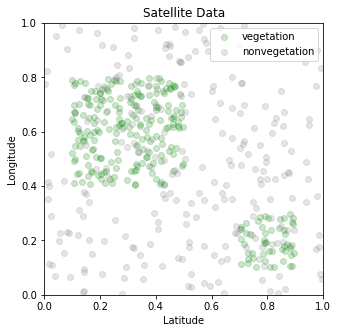

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#scatter plot the data
scatter_plot_data(x, y, ax)

ax.set_title('Satellite Data')
ax.legend(loc='best')
plt.show()

**Exercise 1**: Before trying anything, which classification model do you think will do better on this dataset: logistic regression (with non-linear boundaries) or decision tree? Justify your answer.

**Exercise 2**: Fit a decision tree and a polynomial logistic regression model to this dataset. Choose optimal hyperparameters for both the tree and the polynomial model.

In [15]:
# Step 1: instantiate a DecisionTreeClassifier model with maximum depth of your choice
# Hint: you may want to look at this for reference
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# COMPLETE
tree = DecisionTree(max_depth=20)
#
# Step 2: fit the decision tree to our data
tree.fit(x, y)

DecisionTreeClassifier(max_depth=20)

In [16]:
# Step 1: transform your training and testing data into polynomial features with degree of your choice
polynomial_degree = 10
polynomial_features = PolynomialFeatures(polynomial_degree)
# Step 2: fit the PolynomialFeatures model to our data
polynomial_features.fit(x)
# Step 3: add polynomial powers to our data
x_poly = polynomial_features.transform(x)

# Step 4: fit a logistic regression model on top of your polynomial features
# COMPLETE
logistic_poly = LogisticRegression()
logistic_poly.fit(x_poly, y)

LogisticRegression()

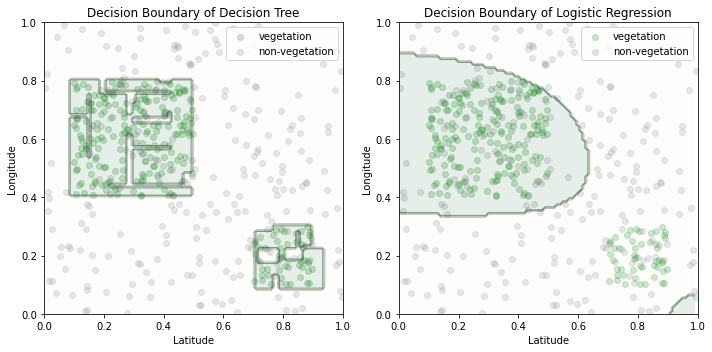

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Step 5: plot the decision tree boundary
plot_decision_boundary(x, y, tree, ax[0])

ax[0].set_title('Decision Boundary of Decision Tree')

# Step 6: plot the logistic regression boundary
plot_decision_boundary(x, y, logistic_poly, ax[1], poly_degree=10)

ax[1].set_title('Decision Boundary of Logistic Regression')
plt.tight_layout()
plt.show()

**Exercise 3:** Which model fits our data better? Is this what you expected?

---

## When is a random forest better than a decision tree?
In this section we explore the advantages of random forests over decision trees.

## Loading `csv` data stored in `github` into `colab`

**Instructions**: run the cell below.

In [18]:
#load the satellite image dataset from an url
sat_img_2 = pd.read_csv('https://raw.githubusercontent.com/cs109Alabs/lab_files/master/Lab_8/datasets/dataset_4.txt', header=None)
#get the long/lat coords
x = sat_img_2.values[:, :-1]
#get the class labels
y = sat_img_2.values[:, -1]

#### Visualize the data

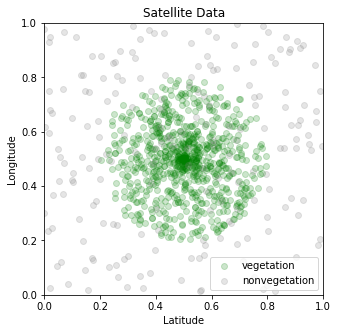

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# scatter plot the data
scatter_plot_data(x, y, ax)

ax.set_title('Satellite Data')
ax.legend(loc='best')
plt.show()

**Exercise 4:** Fit a very deep decision tree (say with depth 1000) to the data and visualize the decision boundary.

In [20]:
# Step 1: instantiate a DecisionTreeClassifier model with maximum depth of 1000
# Hint: you may want to look at this for reference
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# COMPLETE
tree = DecisionTree()
#
# Step 2: fit the decision tree to our data
tree.fit(x, y)
# COMPLETE

DecisionTreeClassifier()

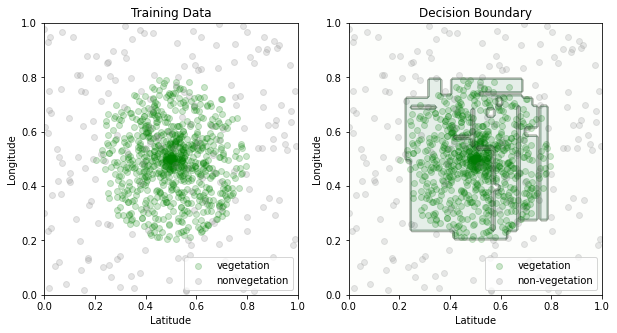

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Step 3: visualize the data
scatter_plot_data(x, y, ax[0])
ax[0].set_title('Training Data')

# Step 5: plot the decision tree boundary
plot_decision_boundary(x, y, tree, ax[1])
ax[1].set_title('Decision Boundary')

plt.show()

**Exercise 5:**: Why isn't the tree's decision boundary a circle? Is this a problem (**Hint**: relate what you're seeing to the concepts of overfitting, high variance and generalization error)?

**Exercise 6:** Investigate the variance of this tree.
Boostrap two different sets of training datapoints from your data, and fit two different trees. Compare their decision boundaries. Relate what you're seeing to the concepts of overfitting, high variance and generalization error.

***Hint*** *: To boostrap, you can use the helper fuction called `bootstrap_data` define above*

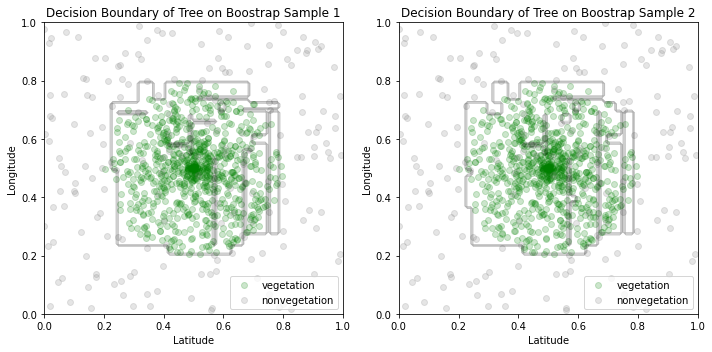

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Step 0: plot the data on subplot 1 and subplot 2
scatter_plot_data(x, y, ax[0])
scatter_plot_data(x, y, ax[1])

ax[0].set_title('Decision Boundary of Tree on Boostrap Sample 1')
ax[1].set_title('Decision Boundary of Tree on Boostrap Sample 2')

# Step 1: boostrap sample data
x_sample, y_sample = (x, y)

# Step 2: fit a decision tree
tree = DecisionTree()
tree.fit(x_sample, y_sample)

# Step 3: plot the decision tree boundary 
plot_decision_boundary(x, y, tree, ax[0], plot_boundary_only=True)

# Step 4: boostrap another sample data
x_sample, y_sample = (x, y)

# Step 5: fit a decision tree
tree = DecisionTree()
tree.fit(x_sample, y_sample)

# Step 6: plot the decision tree boundary
plot_decision_boundary(x, y, tree, ax[1], plot_boundary_only=True)

plt.tight_layout()

**Exercise 7**: Fit a random forest model to the same dataset and visualize its decision boundary. You must choose an appropriate value for `n_estimators` and `max_depth`. Would you prefer to use a random forest model for this decision set or a very deep decision tree. Support your answer using concepts from lecture.

In [33]:
# Step 1: instantiate a DecisionTreeClassifier model with maximum depth of your choice
# Hint: you may want to look at this for reference
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# COMPLETE
rf = RandomForest()
#
# Step 2: fit the random forest to our data
rf.fit(x, y)

RandomForestClassifier()

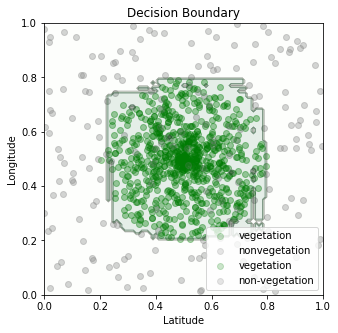

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Step 3: visualize the data
scatter_plot_data(x, y, ax)
ax.set_title('Training Data')

# Step 5: plot the random forest boundary
plot_decision_boundary(x, y, rf, ax)
ax.set_title('Decision Boundary')

plt.show()